# Exploration_SSAC 11 News Text Abstractive Summarization Project

Keywords : Text Summarization, Extractive/Abstractive Summarization, seq2seq(RNN Network), LSTM/Vanilla-RNN, SOS-EOS Token, Attention Mechanism, Encoder-Decoder 

#### Text Summarization    
텍스트의 전후 정보 손실 발생이 최소화되게 정보를 압축하여야 하며, 문서 원문이 담고 있는 정보를 최대한 보존하고 있어야 함.   

#### Extractive Summarization    
원문에서 그대로 문장을 추출해서 요약하는 방식. 이 방식은 문장 원문에서 중요도가 높은 문장일 수 있지만 추출한 문장끼리 연결이 어색할 수 있음.   

#### Abstractive Summarization     
원문으로부터 내용이 요약된 새로운 문장을 생성하는 방식.

#### Seq2Seq (Sequence-to-Sequence)     
첫번째 인코더로 데이터를 입력하면 그 데이터는 하나의 고정된 벡터로 변환하게 되며, 그 변환된 벡터는 문맥 정보를 가지고 있게 됨.(Context Vector) 이 문맥 정보를 가지고 있는 벡터를 계속 layer를 거치면서 요약 진행.

##### SOS-EOS Token     
seq2seq 구조에서 한 데이터의 시작과 종료를 알려주기 위해 앞/뒤에 토큰을 추가하여 전처리 과정을 거쳐야 함.

##### Attention Mechanism    
기존의 RNN 계열의 네트워크 구조는 네트워크 상의 마지막 time step의 hidden state의 정보만 가중합으로 계산되어 입력 시퀀스의 많은 정보가 손실이 되게 되는데,    
이를 보완하기 위해 인코더의 컨텍스트 벡터에 각 state의 가중합을 고려하게 된다.

##### Process of Project        
Newssummarymore.csv :: 뉴스 기사 데이터 요약    

1) 데이터 수집/로드    
2) 데이터 전처리 및 분석(추상적 요약)   
3) 어텐션 메커니즘 적용(추상적 요약)    
4) 실제 결과와 요약문 비교    
5) Summa을 이용해서 추출적 요약   

##### 필요한 모듈 import

In [1]:
import nltk #Natural Language ToolKit
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/ssac22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1) 데이터 수집/로드

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
95655,"Rickshaw puller sexually assaulted, murdered i...",A 40-year-old rickshaw puller died after he wa...
79572,Ram Nath Kovind 1st President from UP; Know mo...,"Elected India's 14th President, Ram Nath Kovin..."
48432,Users misspelling 'Bitcoin' to bypass FB ban o...,Users on Facebook have been found advertising ...
39935,Rajeev Misra may succeed Masayoshi Son as Soft...,"SoftBank Vision Fund's CEO Rajeev Misra, who h..."
65398,Militants who surrender will be accepted: J&K ...,Jammu and Kashmir Police on Monday said that t...
70708,Haryana begins probe into illegal abortions at...,The Haryana government has initiated a probe t...
79330,Watch meant for Putin fetches Ã¢ÂÂ¹7 crore in...,A Patek Philippe timepiece allegedly meant for...
86136,Trump Hotels partners with Chawla Hotels for n...,The Trump Organisation is partnering with an I...
23839,St Stephen's College cancels Mamata's event wi...,Delhi University's St Stephen's College has ca...
600,Humbled by this recognition: Actor Mohanlal on...,"Malayalam actor Mohanlal, who was conferred wi..."


In [66]:
len(data)

98360

In [4]:
# text :: 본문, headlines :: 이미 요약된 데이터(제목)
data.columns

Index(['headlines', 'text'], dtype='object')

## 2) 데이터 전처리 및 분석 (추상적 요약)     

* 텍스트 정규화 및 정제    
* 불용어 제거 유무 판단

In [5]:
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


* 두 컬럼의 중복을 제외한 데이터의 수가 다른 것을 확인 --> 중복을 제거해주고 데이터 수를 맞춰주는 과정 필요

In [6]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


* text 컬럼 데이터에 중복되는 데이터가 있다는 의미이기 때문에 text 기준으로 중복 제거

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


* 중복을 제거하고, null값을 확인하여 데이터 정제 

In [8]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


#### 텍스트 정규화 / 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
data.sample(10)

,headlines,text
60386,BarÃÂ§a go 10 points clear of Real after goal...,Cristiano Ronaldo extended his run without a g...
42660,US mom arrested after video shows baby smoking...,Police in US' North Carolina arrested a 20-yea...
547,"Mom could say things and get away with it, I c...","Actress Sara Ali Khan, while talking about how..."
92561,Don't take law into your hands: Adityanath tel...,Uttar Pradesh CM Yogi Adityanath on Thursday s...
96815,Jawan killed in accident saves lives by donati...,"Twenty-two-year-old jawan Roshan Kumar, who pa..."
32672,BJP caused biggest damage to Hinduism: Dwarka ...,Shankaracharya Swaroopanand Saraswati of Dwark...
89641,How much salary do the CEOs of India's top sta...,"Among India's top startups' CEOs, Paytm's Vija..."
96519,Air India staffer as equally at fault as Gaikw...,Congress leaders has defended Shiv Sena MP Rav...
12624,SC refuses urgent hearing of PIL for FIRs in #...,The Supreme Court has declined urgent hearing ...
36599,Don't know why India obsessed with impeachment...,"Justice Chelameswar, one of the Supreme Court ..."


In [12]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

* 비교적 짧은 headlines 데이터는 불용어를 제거하지 않고 사용      
* News는 Text를 요약하여 headlines를 작성하기 때문에 비교적 headlines가 짧을 것이다. 때문에, headlines에 관련된 불용어는 제거하지 않고 학습에 활용할 것

##### Text 컬럼의 경우 데이터 전처리 + 불용어 제거 실행

In [14]:
clean_text = []

# 전체 Text 데이터에 대한 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

##### Headlines 컬럼의 경우 데이터 전처리 + 불용어 제거 X

In [17]:
clean_headlines = []

# 전체 Headlines 데이터에 대한 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [18]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [20]:
data.sample(5)

,headlines,text
81724,protesters clash with police ahead of summit i...,hundreds protesters clashed police torched pat...
8862,himalaya new ad promises wellness and happines...,himalaya drug company launched first brand cam...
7697,picture of george hw bush dog resting near his...,picture late us president george hw bush servi...
57469,maharashtra govt signs agreements on health ed...,maharashtra government signed agreements vario...
30335,website flaw exposes real time mobile phone lo...,flaw cellular location data collecting website...


In [21]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

* headlines / text 데이터 중복 제거 + Null 데이터 제거 + 불용어 제거 과정을 거치며 데이터 전처리

#### 전처리 완료된 데이터 분포 체크 후, 최대 길이 조정

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


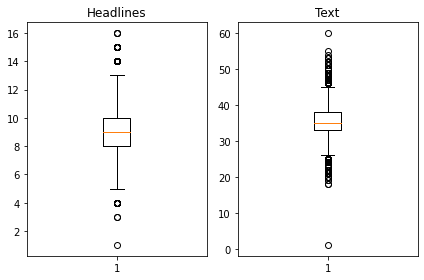

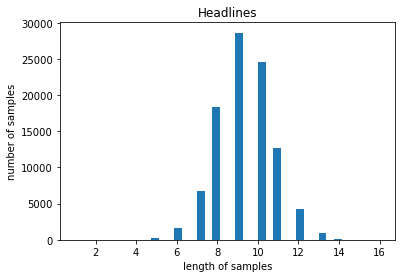

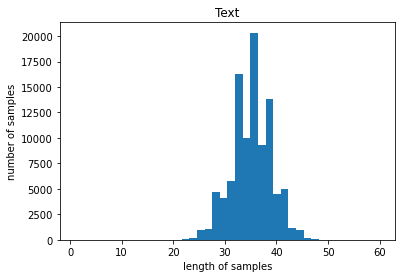

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 데이터가 정규분포를 이루기 때문에 샘플의 정제는 필요하지 않을 것으로 보임

#### SOS-EOS Token 추가    
연속적인 벡터 정보를 저장하기 위해, seq2seq 네트워크 모델 훈련을 위해 디코더의 입력과 레이블에 시작/종료 토큰 추가

In [24]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


* 시작/종료 토큰을 추가해 준 후, 디코더 관련 레이블을 numpy 타입으로 저장하여 벡터화/모델 생성/모델 훈련을 진행할 준비를 하자

In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[46611  8977 62882 ... 51764 14150 95684]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(98360,)
(98360,)
(98360,)


In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19672


In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


#### 정수 인코딩 :: 단어를 벡터화(?)하는 과정

* keras의 Tokenizer() 함수를 활용하여 단어 집합 생성

In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [35]:
threshold = 9 # 위 분포도를 보았을 때, 적절하게 지정
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69689
등장 빈도가 8번 이하인 희귀 단어의 수: 50260
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19429
단어 집합에서 희귀 단어의 비율: 72.12042072637001
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.238734778244351


In [36]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 19,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [37]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[13793, 1016, 16646, 12271, 2978, 579, 7581, 2762, 1099, 3, 512, 751, 2703, 10982, 436, 14, 960, 2354, 1137, 6, 46, 4026, 3496, 1570, 2388, 8282, 1570, 319, 1762, 16646, 49, 2366, 3235, 2920, 2995, 27, 69, 152, 4278, 4132], [77, 3308, 1311, 194, 5658, 1914, 827, 60, 1624, 95, 288, 502, 22, 116, 11590, 19, 4969, 1450, 367, 1450, 4518, 1496, 718, 2704, 3497, 33, 8686, 14304, 10028, 8687, 31, 6801, 21, 5439, 746, 104, 11, 23, 14, 5003, 1], [586, 1647, 1901, 4279, 18399, 1451, 895, 196, 4313, 10246, 262, 1781, 937, 1921, 69, 344, 3526, 1901, 895, 262, 3526, 13794, 1280, 48, 1901, 895, 50, 4246, 1373]]


In [38]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [39]:
threshold = 8
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30170
등장 빈도가 7번 이하인 희귀 단어의 수: 21351
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8819
단어 집합에서 희귀 단어의 비율: 70.76897580377859
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.92842653874058


In [40]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 39, 19, 1062, 3031, 3, 682, 22, 538], [1, 348, 717, 24, 21, 7628, 139, 28, 2916, 774, 34], [1, 165, 1744, 12, 3411, 902, 1884], [1, 120, 5, 4678, 3, 5642, 208, 4, 315], [1, 2542, 1155, 6, 1985, 89, 3, 520, 216, 164, 90]]
target
decoder  [[39, 19, 1062, 3031, 3, 682, 22, 538, 2], [348, 717, 24, 21, 7628, 139, 28, 2916, 774, 34, 2], [165, 1744, 12, 3411, 902, 1884, 2], [120, 5, 4678, 3, 5642, 208, 4, 315, 2], [2542, 1155, 6, 1985, 89, 3, 520, 216, 164, 90, 2]]


In [41]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


/home/ssac22/Downloads/exit/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [43]:
text_max_len = 50
summary_max_len = 12

In [44]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 3) 어텐션 매커니즘 적용

* 모델 설계 ① 함수형 API를 이용해서 인코더 설계

In [47]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 모델 설계 ② 디코더 설계

In [48]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [49]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [50]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [51]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 4) 모델 훈련

In [52]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 116s 377ms/step - loss: 5.4227 - val_loss: 5.0054
Epoch 2/50
308/308 [==============================] - 115s 372ms/step - loss: 4.8386 - val_loss: 4.6274
Epoch 3/50
308/308 [==============================] - 116s 375ms/step - loss: 4.5118 - val_loss: 4.3821
Epoch 4/50
308/308 [==============================] - 118s 383ms/step - loss: 4.2584 - val_loss: 4.1895
Epoch 5/50
308/308 [==============================] - 117s 379ms/step - loss: 4.0603 - val_loss: 4.0570
Epoch 6/50
308/308 [==============================] - 116s 375ms/step - loss: 3.8940 - val_loss: 3.9400
Epoch 7/50
308/308 [==============================] - 116s 376ms/step - loss: 3.7469 - val_loss: 3.8377
Epoch 8/50
308/308 [==============================] - 117s 380ms/step - loss: 3.6202 - val_loss: 3.7613
Epoch 9/50
308/308 [==============================] - 117s 380ms/step - loss: 3.5102 - val_loss: 3.7065
Epoch 10/50
308/308 [==============================] - 117s 379m

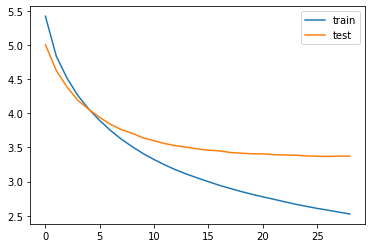

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 5) 인퍼런스 모델 구현 및 테스트

#### 인퍼런스 모델 구현

In [54]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [55]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [56]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [57]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#### 모델 테스트

In [58]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [59]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : one israel leading newspapers described indian prime minister narendra modi important pm world ahead visit country huge expectations us president donald trump visit say much newspaper said added modi leader billion people deserves lot attention 
실제 요약 : narendra modi world most important pm israeli newspaper 
예측 요약 :  pm modi is good indian friend israel president


원문 : congress vice president rahul gandhi would miss anti bjp rally patna rally gujarat travelling norway invitation country foreign ministry rahul said looking forward meeting exchanging ideas political business leaders research institutions norway recently sonia gandhi pulled patna rally 
실제 요약 : rahul gandhi heading to norway won attend anti bjp rally 
예측 요약 :  rahul gandhi leaders leaders attend bjp leaders


원문 : flipkart owned phonepe alleged paytm claim largest upi misleading phonepe explained average phonepe customer transactions per month comparable figure paytm representative normal user behaviour phonepe add

예측 요약 :  kapil sharma reveals he he can never be tried to kiss


원문 : delivering verdict supreme court decriminalising homosexuality india cji dipak misra said lgbt community rights ordinary citizen respect others rights others supreme humanity said views popular morality cannot dictate constitutional rights cji misra called section irrational 
실제 요약 : lgbt community has same rights as any citizen sc 
예측 요약 :  india will be sc judges if he is not cji


원문 : security forces killed three lashkar taiba terrorists encounter district jammu kashmir saturday police personnel injured three ak rifles recovered terrorists comes days top let militant abu dujana aide killed forces state pulwama district 
실제 요약 : three lashkar terrorists killed in encounter in 
예측 요약 :  militants killed in encounter in encounter in kashmir


원문 : government appointed idbi bank managing director ceo mahesh kumar jain deputy governor rbi jain years experience banking previously served ceo state run indian bank post r

예측 요약 :  flipkart co founder invests in startup


원문 : following alleged suicide linkin park singer chester bennington posts wife bennington verified twitter account reportedly hacked claimed cheating husband mike one tweets read kill already proof series tweets deleted 
실제 요약 : tweet by linkin park singer wife claims she cheated on him 
예측 요약 :  singer suicide rihanna after her affair with him


원문 : prime minister narendra modi tuesday visited rajasthan launched road projects worth crore promising change face state modi said work make empty election promises comes ahead rajasthan assembly polls due 
실제 요약 : pm modi launches road projects worth crore in rajasthan 
예측 요약 :  pm modi announces cr for projects in assam


원문 : hina khan accused fraud jewellery brand denied charges sent counter legal notice company defamation tv actress demanded unconditional public apology within five days receiving notice hina took twitter share copy courier receipt notice 
실제 요약 : hina sends counter noti

## 6) Summa를 이용한 추출적 요약

In [60]:
import requests
from summa.summarizer import summarize

In [61]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [62]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [63]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [64]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [65]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


## Result of Project   

자연어 처리 분야의 프로젝트를 하면, 항상 신기하면서도 (아직은 영어 텍스트를 활용하는 것이 익숙하지만) 텍스트를 정수로 변환하여 그 데이터를 훈련시켜 다시 텍스트로 예측할 수 있는 과정이 신기하게 다가온다.    

모든 분야에서 데이터 전처리 과정이 중요하지만, 텍스트 관련 데이터는 데이터 파악 -> 정제 -> 전처리 과정이 가장 중요하게 다가온다.    

요약에서는 추상적 요약/추출적 요약의 기법에 따라 전처리 과정이 다르게 적용이 될 것이고, 이번 프로젝트에서는 추상적 요약을 했기 때문에 정제하는 과정에서 불용어 제거나 다양한 전처리 과정이 최소화되어야 다양한 데이터를 활용하여 훈련시켜 다양한 방식으로 **추상적 요약**이 가능할 것 같아 필요에 의한 전처리 과정만 거쳤다.   

발전한 RNN 기법인 Attention 기법을 활용하여 맥락을 모두 저장할 수 있게 진행하였고, 모델 생성 -> 모델 훈련 -> 모델 예측의 과정을 거쳤다.    

또한, **Summa** 라이브러리를 활용하여 추상적 요약을 더 적절하게 도전해 볼 수 있었다.  

## Good   

꽤나 관심있고, 흥미로웠던 RNN 네트워크를 다시 학습하고, 기반으로 한 Attention 기법을 학습할 수 있었다. 

## Difficulties / Challenges  

데이터 전처리 과정에서 어떠한 부분이 필요한지, 어떻게 진행해야 할지 맥락이 잘 안 잡히는 부분이 있었다. 기본적인 정제 과정은 진행할 수 있었지만, 뉴스 내용에 내한 제목 데이터를 처리할 때 어떠한 요소를 중요하게 고려해야 할 지 파악하는 부분에서 어려움이 있었다.